In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.datasets import make_classification
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import kagglehub
import zipfile
import os
from transformers import pipeline
import torch

/zhome/bb/9/212485/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
combined_data = pd.read_csv("combined_data_preprocessed.csv")
combined_data.head()

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating,cleaned_reviews
0,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,This is an extremely basic course. Machine lea...,By Deleted A,2017-03-18,1,extremely basic course machine learning built ...
1,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,The course is ok but the certification procedu...,By Bruno C,2015-11-09,1,course ok certification procedure messno state...
2,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,"I just started week 3 , I have to admit that I...",By Fadi,2019-04-15,1,started week admit good course explaining idea...
3,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,This course is absolute garbage. You get no f...,By Mathew L,2015-09-25,1,course absolute garbage get feedback quiz assi...
4,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,"However good the material and lectures may be,...",By Rui C,2015-12-12,1,however good material lecture may use outdated...


In [3]:
# Feature Engineering: Calculate Average Rating, Review Count per Course
course_stats = combined_data.groupby('course_id').agg(
    avg_rating=('rating', 'mean'),
    review_count=('rating', 'count')
).reset_index()

# Merge back into original dataframe
combined_data = combined_data.merge(course_stats, on='course_id', how='left')

# 5. Normalize Rating and Review Count
scaler = StandardScaler()
combined_data[['normalized_rating', 'normalized_review_count']] = scaler.fit_transform(
    combined_data[['avg_rating', 'review_count']]
)

In [4]:
combined_data.head()

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating,cleaned_reviews,avg_rating,review_count,normalized_rating,normalized_review_count
0,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,This is an extremely basic course. Machine lea...,By Deleted A,2017-03-18,1,extremely basic course machine learning built ...,4.750522,35895,0.277835,2.014232
1,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,The course is ok but the certification procedu...,By Bruno C,2015-11-09,1,course ok certification procedure messno state...,4.750522,35895,0.277835,2.014232
2,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,"I just started week 3 , I have to admit that I...",By Fadi,2019-04-15,1,started week admit good course explaining idea...,4.750522,35895,0.277835,2.014232
3,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,This course is absolute garbage. You get no f...,By Mathew L,2015-09-25,1,course absolute garbage get feedback quiz assi...,4.750522,35895,0.277835,2.014232
4,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,"However good the material and lectures may be,...",By Rui C,2015-12-12,1,however good material lecture may use outdated...,4.750522,35895,0.277835,2.014232


In [ ]:
# # Select 1% of the data for testing
# sampled_data = combined_data.sample(frac=0.01, random_state=42)

# # Check if CUDA (GPU) is available
# device = 0 if torch.cuda.is_available() else -1
# print(f"CUDA Available: {torch.cuda.is_available()}")

# # Load the pre-trained sentiment analysis model
# MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment"
# classifier = pipeline(
#     "text-classification", 
#     model=MODEL_NAME, 
#     device=device, 
#     truncation=True, 
#     padding=True, 
#     max_length=512
# )

# # Map the model's labels to sentiment categories
# label_mapping = {
#     'LABEL_0': 'negative',
#     'LABEL_1': 'neutral',
#     'LABEL_2': 'positive'
# }

# # Function to classify sentiment for a batch of reviews
# def classify_batch(batch):
#     reviews = batch['reviews'].tolist()  # Convert reviews column to a list
#     results = classifier(reviews)  # Perform sentiment classification
#     # Extract sentiments and scores
#     return [(label_mapping[result['label']], result['score']) for result in results]

# # Process the dataset in batches for efficiency
# def process_in_batches(df, batch_size=64):
#     sentiment_results = []

#     for start in range(0, len(df), batch_size):
#         batch = df.iloc[start:start + batch_size]  # Slice the DataFrame into batches
#         sentiments = classify_batch(batch)  # Classify the batch
#         sentiment_results.extend(sentiments)  # Append the results

#         # Progress tracking
#         print(f"Processed {min(start + batch_size, len(df))}/{len(df)} rows")

#     return sentiment_results

# # Apply sentiment analysis to the entire dataset
# batch_size = 64  # Adjust batch size based on memory (increase if using GPU)
# sentiments_with_scores = process_in_batches(sampled_data, batch_size)

# # Separate sentiment and score into two new columns
# sampled_data['sentiment'] = [sentiment for sentiment, score in sentiments_with_scores]
# sampled_data['sentiment_score'] = [score for sentiment, score in sentiments_with_scores]

# # Save the updated dataset
# output_file = "sampled_data_with_sentiment.csv"
# sampled_data.to_csv(output_file, index=False)
# print(f"Sentiment analysis completed. Results saved to {output_file}")

# # Preview the updated DataFrame
# print(sampled_data[['reviews', 'sentiment', 'sentiment_score']].head())

CUDA Available: False
Processed 64/14546 rows
Processed 128/14546 rows
Processed 192/14546 rows
Processed 256/14546 rows
Processed 320/14546 rows
Processed 384/14546 rows
Processed 448/14546 rows
Processed 512/14546 rows
Processed 576/14546 rows
Processed 640/14546 rows
Processed 704/14546 rows
Processed 768/14546 rows
Processed 832/14546 rows
Processed 896/14546 rows
Processed 960/14546 rows
Processed 1024/14546 rows
Processed 1088/14546 rows
Processed 1152/14546 rows
Processed 1216/14546 rows
Processed 1280/14546 rows
Processed 1344/14546 rows
Processed 1408/14546 rows
Processed 1472/14546 rows
Processed 1536/14546 rows
Processed 1600/14546 rows
Processed 1664/14546 rows
Processed 1728/14546 rows
Processed 1792/14546 rows
Processed 1856/14546 rows
Processed 1920/14546 rows
Processed 1984/14546 rows
Processed 2048/14546 rows
Processed 2112/14546 rows
Processed 2176/14546 rows
Processed 2240/14546 rows
Processed 2304/14546 rows
Processed 2368/14546 rows
Processed 2432/14546 rows
Proces

In [ ]:
# # Load the pre-trained BERT sentiment analysis model
# MODEL_NAME = "nlptown/bert-base-multilingual-uncased-sentiment"  # Pre-trained BERT model for sentiment analysis

# classifier = pipeline(
#     "sentiment-analysis",
#     model=MODEL_NAME,
#     device=device,
#     truncation=True,
#     padding=True,
#     max_length=512
# )

# # Map star ratings to sentiment categories
# def map_stars_to_sentiment(star_rating):
#     if star_rating in ['1 star', '2 stars']:
#         return 'negative'
#     elif star_rating == '3 stars':
#         return 'neutral'
#     elif star_rating in ['4 stars', '5 stars']:
#         return 'positive'
#     else:
#         return 'unknown'

# # Function to classify sentiment for a batch of reviews
# def classify_batch(batch):
#     reviews = batch['reviews'].tolist()  # Convert reviews column to a list
#     results = classifier(reviews)  # Perform sentiment classification

#     # Map star ratings to sentiments
#     sentiments_and_scores = []
#     for result in results:
#         sentiment = map_stars_to_sentiment(result['label'])
#         sentiments_and_scores.append((sentiment, result['score']))
#     return sentiments_and_scores

# # Process the dataset in batches for efficiency
# def process_in_batches(df, batch_size=64):
#     sentiment_results = []

#     for start in range(0, len(df), batch_size):
#         batch = df.iloc[start:start + batch_size]  # Slice the DataFrame into batches
#         sentiments = classify_batch(batch)  # Classify the batch
#         sentiment_results.extend(sentiments)  # Append the results

#         # Progress tracking
#         print(f"Processed {min(start + batch_size, len(df))}/{len(df)} rows")

#     return sentiment_results

# # Apply sentiment analysis to the entire dataset
# batch_size = 64  # Adjust batch size based on memory (increase if using GPU)
# sentiments_with_scores = process_in_batches(combined_data, batch_size)

# # Separate sentiment and score into two new columns
# combined_data['sentiment'] = [sentiment for sentiment, score in sentiments_with_scores]
# combined_data['sentiment_score'] = [score for sentiment, score in sentiments_with_scores]

# # # Save the updated dataset
# # output_file = "combined_data_with_sentiment.csv"
# # combined_data.to_csv(output_file, index=False)
# # print(f"Sentiment analysis completed. Results saved to {output_file}")

# # Preview the updated DataFrame
# print(combined_data[['reviews', 'sentiment', 'sentiment_score']].head())


In [8]:
# Combine course titles and reviews
combined_data['combined_text'] = combined_data['name'] + " " + combined_data['cleaned_reviews']
combined_data['combined_text'] = combined_data['combined_text'].fillna("")

Cluster Distribution:
cluster
4    5573
3    4270
0    1883
1    1873
2     947
Name: count, dtype: int64

Top terms in each cluster:

Cluster 0:
  19
  able

Cluster 1:
  19
  able

Cluster 2:
  19
  able

Cluster 3:
  19
  able

Cluster 4:
  19
  able


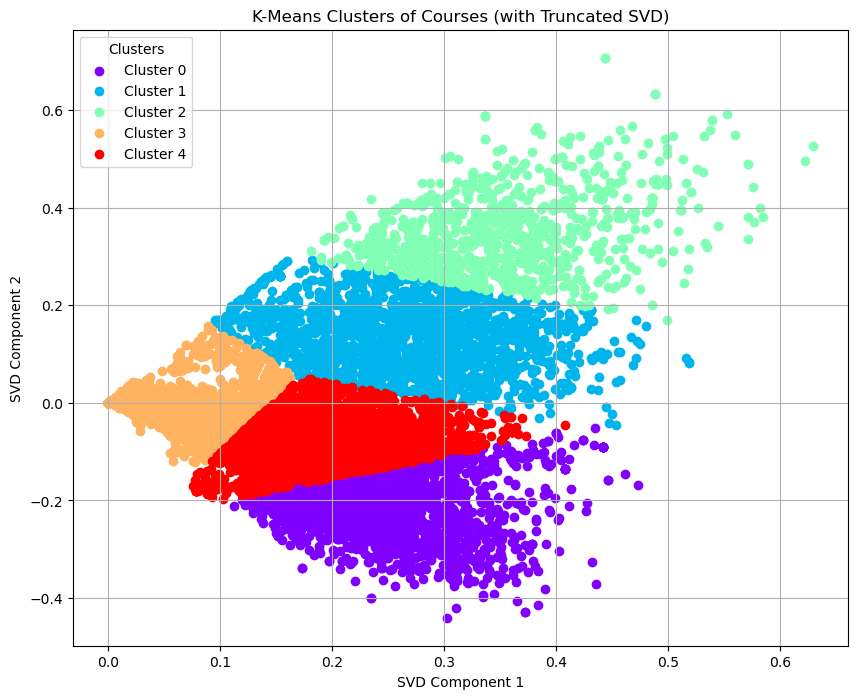

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# 1. Reduce the data size by sampling 1% of the combined_data
sampled_df = combined_data.sample(frac=0.01, random_state=42)

# 2. Initialize the TF-IDF vectorizer with unigrams and a maximum of 500 features
vectorizer = TfidfVectorizer(stop_words='english', max_features=500, ngram_range=(1, 1))

# 3. Create the sparse TF-IDF matrix
tfidf_matrix = vectorizer.fit_transform(sampled_df['combined_text'])

# 4. Apply Truncated SVD for dimensionality reduction (to 2 components for visualization)
n_components = 2  # Choose the number of dimensions for visualization
svd = TruncatedSVD(n_components=n_components, random_state=42)
reduced_features = svd.fit_transform(tfidf_matrix)

# 5. Apply KMeans clustering to the reduced features
optimal_clusters = 5  # Based on previous analysis or assumptions
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(reduced_features)

# 6. Add the cluster labels to the sampled_df
sampled_df['cluster'] = kmeans.labels_

# 7. Check the number of instances in each cluster
print("Cluster Distribution:")
print(sampled_df['cluster'].value_counts())

# 8. Print top terms for each cluster based on the cluster centers
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

print("\nTop terms in each cluster:")
for i in range(optimal_clusters):
    print(f"\nCluster {i}:")
    for ind in order_centroids[i, :10]:  # Print the top 10 terms for each cluster
        print(f"  {terms[ind]}")

# 9. Generate colors for the visualization
colors = plt.cm.rainbow(np.linspace(0, 1, optimal_clusters))

# 10. Create a scatter plot to visualize the clusters
plt.figure(figsize=(10, 8))
for i in range(optimal_clusters):
    cluster_points = reduced_features[sampled_df['cluster'] == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[i], label=f'Cluster {i}')

plt.title('K-Means Clusters of Courses (with Truncated SVD)')
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.legend(title="Clusters")
plt.grid(True)
plt.show()

In [14]:
# Check 10 reviews from each cluster
reviews_per_cluster = {}
for cluster_id in range(optimal_clusters):
    cluster_reviews = sampled_df[sampled_df['cluster'] == cluster_id]['reviews']
    reviews_per_cluster[cluster_id] = cluster_reviews.sample(n=10, random_state=42).tolist()

# Print 10 reviews from each cluster
for cluster_id, reviews in reviews_per_cluster.items():
    print(f"\nCluster {cluster_id} Reviews:")
    for review in reviews:
        print(f"- {review}")


Cluster 0 Reviews:
- The course structure and content is just perfect for beginners, especially for those with no formal programming experience. I acquired significant programming skills, and realized its so much fun!
- Great course, thank you very much! 
- Great introduction to machine learning for beginners! The course is well paced and easy to follow. The assignments and quiz helped gain a better insight into the algorithms that were covered in the course.Definitely recommend this course!!!
- Great learning with Coursera....enjoyed learning and doing assignments
- This is a great course, both for those who want to start and those who have some experiences but want to know all tricks and debugging or point to enhance their skills.
- Publicity stunt
- I highly recommend this course if you are new to Machine Learning. The course structure is really good and the instructor is highly experienced. The course is highly efficient for a computer science major and there is no excessive talk 